# CNN_Plant_Seedling_Classification


此範例會使用模組化的軟體設計方法，它將一個大型的程式或專案拆分成更小、更容易管理的模塊或組件。每個模塊執行特定的功能或處理特定的任務，並且可以獨立開發、測試和維護。這樣的設計有助於提高程式碼的可讀性、可重用性和可維護性，並且讓不同團隊的開發者能夠協作更輕鬆。在PyTorch中，模組化通常表現為創建獨立的模型、函數和類別，每個模塊負責特定的任務，並且可以輕鬆組合在一起以構建更大的深度學習模型。

本次課程將會把pytorch訓練流程分成以下幾個模組來教學:
1. `Dataset`
2. `Dataloader`
3. `Model`
4. `Train` Function
5. `Valid` Function
6. `Plot Curve` Function
7. `Predict` Function
8. `Main` Function
9. `Addition` Customize model

## Download Datasets

此範例使用 kaggle 上縮減過的 Plant Seedlings Classification資料集，請先至雲端 (https://drive.google.com/file/d/1QhirbRNJG_-XbiqIpxu5IWSspKGPAoyR/view?usp=sharing) 中下載`plant-seedlings-classification.zip`，透過`google.colab`套件，我們可以讓 Colab 上的程式直接讀取自己的雲端硬碟。


執行下面的code之前，請先確保自己的google drive中已經有`plant-seedlings-classification.zip`檔案，並確保檔案位置正確。

掛載自己的google drive後，雲端硬碟的根目錄為: `/content/gdrive/MyDrive/`



In [ ]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/plant_seedlings_classification/' # dataset's dir you want to unzip

if not os.path.exists(data_dir):
  zip_dir = '/content/gdrive/MyDrive/plant-seedlings-classification.zip' # your zip file's dir

  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(data_dir)


Mounted at /content/gdrive


## Import Package

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm
from torchvision.datasets import ImageFolder

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

## Config
Config of Hyperparameter

In [ ]:
# Set Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.001
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## 1. Custom Pytorch Dataset


A `Dataset` in Pytorch should have three methods:

1. `__init__`: Read data & preprocess
2. `__len__`: return a integer indicating the size of the dataset
3. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
├── train
│   ├── Black-grass (Class name)
│   │   ├── 0050f38b3.png
│   │   ├── 0183fdf68.png
│   │   ├── 0260cffa8.png
│   │   ├── ...
│   └── Charlock
│   │   ├── 022179d65.png
│   │   ├── 02c95e601.png
│   │   ├── 04098447d.png
│   │   ├── ...
│   └── ...
├── test
│   ├── 0021e90e4.png
│   ├── 003d61042.png
│   ├── 007b3da8b.png
│   ├── ...
```

We can simply find all the pngs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the png (loaded as `PIL.Image`) into pytorch tensor.

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [ ]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0)
        return img

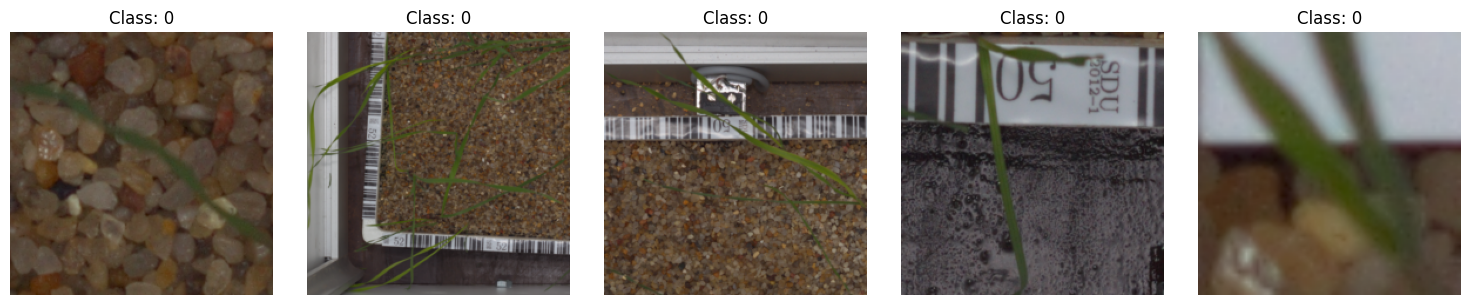

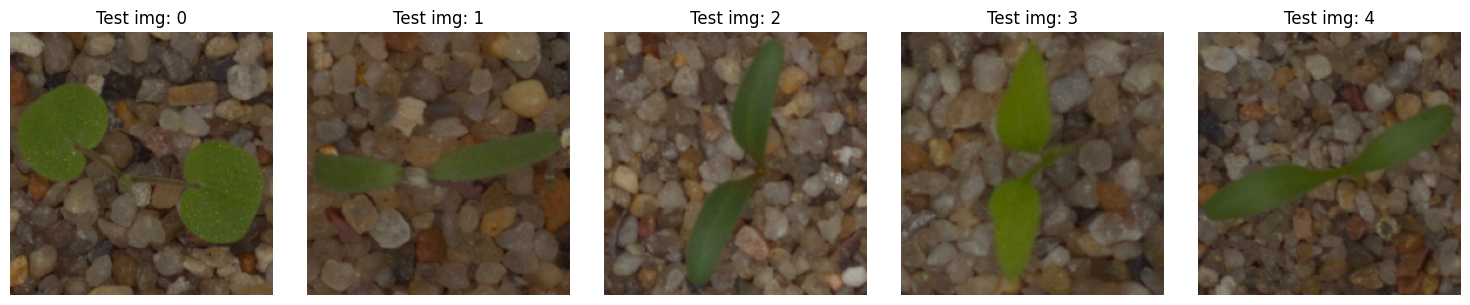

In [ ]:
# visualize dataset item for debug
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])

whole_set = Train_data(
    root_dir=train_dir,
    transform=transform
)

test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(f'Class: {label}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f'Test img: {i}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

## 2. Split train, valid set and Create Dataloader:


In [ ]:
train_set, valid_set = random_split(whole_set, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 3. Create Model

A `nn.Module` in Pytorch should have two methods:

1. `__init__`: Initialize your model & define layers
2. `forward`: Compute output of your Model



In [ ]:
class resnet_50(nn.Module):
    def __init__(self, num_classes = 12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # set model layers trainable
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [ ]:
# test model for debug

model = resnet_50(num_classes=12).cuda()
# print(model)
x = torch.rand(1, 3, 224, 224).cuda()
y = model(x)
print(x)
print(y)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.0MB/s]


tensor([[[[0.8029, 0.5658, 0.1798,  ..., 0.5827, 0.1589, 0.7190],
          [0.8900, 0.1778, 0.7798,  ..., 0.6439, 0.3762, 0.9102],
          [0.0396, 0.8253, 0.5041,  ..., 0.3559, 0.8796, 0.4281],
          ...,
          [0.6868, 0.9594, 0.2596,  ..., 0.7653, 0.0920, 0.8888],
          [0.9415, 0.6694, 0.8680,  ..., 0.2571, 0.5027, 0.0523],
          [0.7893, 0.8385, 0.4769,  ..., 0.0591, 0.7104, 0.6341]],

         [[0.2648, 0.1887, 0.3485,  ..., 0.6109, 0.6109, 0.4792],
          [0.7259, 0.7949, 0.7367,  ..., 0.7845, 0.3419, 0.7772],
          [0.8503, 0.1152, 0.1460,  ..., 0.1484, 0.5407, 0.6791],
          ...,
          [0.0200, 0.3816, 0.8969,  ..., 0.9601, 0.0573, 0.3459],
          [0.1138, 0.5809, 0.9756,  ..., 0.7721, 0.7168, 0.6435],
          [0.8989, 0.6052, 0.7393,  ..., 0.4113, 0.3823, 0.5141]],

         [[0.3618, 0.1454, 0.0233,  ..., 0.2615, 0.7032, 0.7502],
          [0.1744, 0.7026, 0.8793,  ..., 0.9849, 0.7250, 0.0196],
          [0.4749, 0.3356, 0.6033,  ..., 0

## 4. Define Train Function(for one epoch):


In [ ]:
def train(model, criterion, optimizer, train_loader, epoch, total_epochs, batch_size):
    model.train()
    train_loss, train_acc = [], []

    tqdm_iter = tqdm(train_loader, desc="Epoch: {}/{} ({}%) | Training loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch_idx, (data, label) in enumerate(tqdm_iter):
        data, target = data.cuda(), label.cuda()
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += acc

        tqdm_iter.set_description("Epoch: {}/{} ({}%) | Training loss: {:.6f} | Training Acc: {:.6f}".format(
        epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [ ]:
# debug "train" function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss, acc = train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

2.178413847514561 0.34330357142857143


## 5. Define Valid Function(for one epoch):


In [ ]:
def valid(model, criterion, valid_loader, epoch, total_epochs, batch_size):
    model.eval()

    tqdm_iter = tqdm(valid_loader, desc="Epoch: {}/{} ({}%) | Valid loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(tqdm_iter):
            data, target = data.cuda(), label.cuda()
            output = model(data)
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean().item()
            epoch_loss += loss.item()
            epoch_acc += acc

            tqdm_iter.set_description("Epoch: {}/{} ({}%) | Valid loss: {:.6f} | Valid Acc: {:.6f}".format(
            epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

In [ ]:
# debug "valid" function
criterion = nn.CrossEntropyLoss()
loss, acc = valid(
    model,
    criterion,
    valid_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

239.10440911187067 0.23615803321202597


## 6. Plot Learning Curve Function:

In [ ]:
def Plot(title, ylabel, epochs, train_loss, valid_loss):
    plt.figure()
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.legend(['train', 'valid'], loc='upper left')

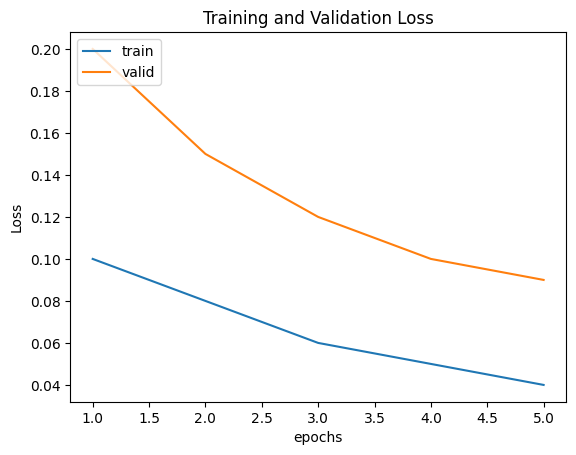

In [ ]:
# debug "Plot" function
debug_epochs = [1, 2, 3, 4, 5]
debug_train_loss = [0.1, 0.08, 0.06, 0.05, 0.04]
debug_valid_loss = [0.2, 0.15, 0.12, 0.1, 0.09]

Plot("Training and Validation Loss", 'Loss', debug_epochs, debug_train_loss, debug_valid_loss)

plt.show()

## 7. Predict Function:

In [ ]:
def predict(loader, model):
    model.eval()
    preds = []
    for data in tqdm(loader):
        pred = model(data.cuda())
        cls = torch.argmax(pred, dim=1)
        preds.append(cls)

    return preds

In [ ]:
# Visualize Predict result
def view_pred_result(preds, num_images_to_display=5):
    labels = ['Black-grass', 'Charlock' , 'Cleavers' , 'Common Chickweed' , 'Common wheat' , 'Fat Hen' , 'Loose Silky-bent' , 'Maize' , 'Scentless Mayweed' , 'Shepherds Purse', 'Small-flowered Cranesbill' , 'Sugar beet']
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i, img in enumerate(test_set):
        axs[i].imshow(img[0].permute(1, 2, 0))
        axs[i].set_title(labels[preds[i].item()])
        axs[i].axis('off')

        num_images_to_display -= 1
        if num_images_to_display == 0:
            break

    plt.tight_layout()
    plt.show()

  0%|          | 0/794 [00:00<?, ?it/s]

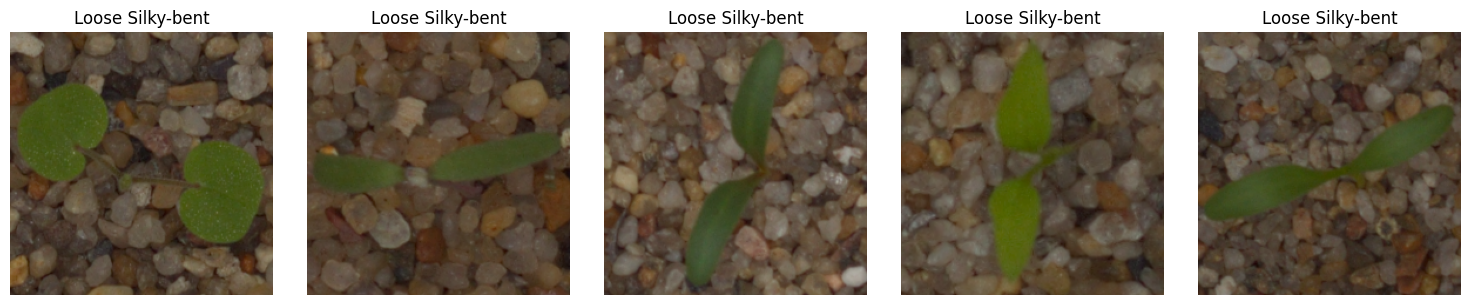

In [ ]:
# debug "Predict" function & "View_Predict_result" function
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])
test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)
model = resnet_50(num_classes=12).cuda()

preds = predict(test_set, model)
view_pred_result(preds)

## 8. Addition: Customize your own model
Create your own deep learning model, by define the inner layers in hand-craft<br>
Example for VGG16 model: https://arxiv.org/abs/1409.1556


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=12):
        super(VGG16, self).__init__()
        # input layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        #  classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## 9. Main Function(training pipeline):
1. `Set Hyperparameters`: `batct_size`, `learning rate`, `epochs`...
2. `Initial`: initial `dataset`, `dataloader`, `model`
3. `Train`: Do train
4. `Valid`: Do valid
5. repeat `3.`  `4.` epochs times
6. `Plot curve`: Plot learning curve to observe the learning progress
7. `Predict`: Use the trained model to predict the results of the test set

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 7.348645523616246, Avg train acc: 0.1340838508946555


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 2.3143939442104764, Avg valid acc: 0.1807383033964369


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 2.2669550827571325, Avg train acc: 0.1938082299062184


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 2.157360394795736, Avg valid acc: 0.182474414507548


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 2.108179681641715, Avg train acc: 0.23914984464645386


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.8039815425872803, Avg valid acc: 0.3424707618024614


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 2.004429180281503, Avg train acc: 0.2976319875035967


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.8185955286026, Avg valid acc: 0.35224780771467423


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.9056404215948923, Avg train acc: 0.3217391303607396


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.6825365490383573, Avg valid acc: 0.42927631735801697


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.8750203336988176, Avg train acc: 0.3583462732178824


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.6244560082753499, Avg valid acc: 0.44426169660356307


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.8257215976715089, Avg train acc: 0.37422360266957966


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.76895805199941, Avg valid acc: 0.4107273386584388


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.721257107598441, Avg train acc: 0.40454192502158026


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5068918996387057, Avg valid acc: 0.5317982468340132


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.685250312941415, Avg train acc: 0.41296583839825224


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4694541692733765, Avg valid acc: 0.5584795342551337


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.6486593587057932, Avg train acc: 0.4232725156205041


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4989192220899794, Avg valid acc: 0.4796235395802392


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.6872155904769897, Avg train acc: 0.4138586955411094


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.6536802848180134, Avg valid acc: 0.4241593579451243


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.6521885905947005, Avg train acc: 0.42408773388181414


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4995256529914007, Avg valid acc: 0.530701756477356


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.5910843985421317, Avg train acc: 0.44823369554110937


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.437171631389194, Avg valid acc: 0.56725146373113


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.5458749055862426, Avg train acc: 0.4635093169552939


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4443910254372492, Avg valid acc: 0.55162646373113


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.5068367515291488, Avg train acc: 0.4725349383694785


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.470970590909322, Avg valid acc: 0.5434027777777778


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.5249374389648438, Avg train acc: 0.46385869554110937


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4350304868486192, Avg valid acc: 0.5898209081755744


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.5533485582896642, Avg train acc: 0.46123835359300885


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4330607387754652, Avg valid acc: 0.5208333333333334


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.4719591106687273, Avg train acc: 0.49243012411253795


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4534115923775568, Avg valid acc: 0.5104166666666666


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.44060138293675, Avg train acc: 0.5038431678499494


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3230723937352498, Avg valid acc: 0.5897295342551337


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.4930120876857214, Avg train acc: 0.477115683896201


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3927109903759427, Avg valid acc: 0.5903691516982185


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.4391794306891306, Avg train acc: 0.5125776393072946


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.347526126437717, Avg valid acc: 0.6018823120329115


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3664178098951067, Avg train acc: 0.5226902178355626


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2749590873718262, Avg valid acc: 0.6119334830178155


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.4331786598478045, Avg train acc: 0.5087538821356637


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5491709576712713, Avg valid acc: 0.5045687125788795


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3981915031160628, Avg train acc: 0.5241847821644374


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3837118016348944, Avg valid acc: 0.5683479507764181


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3435818501881192, Avg train acc: 0.5430318321500506


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2913678354687161, Avg valid acc: 0.5926535063319736


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.346819966179984, Avg train acc: 0.5432259321212769


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2609920236799452, Avg valid acc: 0.5340826014677683


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2928867374147688, Avg train acc: 0.5564246892929077


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1355834934446547, Avg valid acc: 0.6285635961426629


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.272414527620588, Avg train acc: 0.5604425464357649


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.335930691825019, Avg valid acc: 0.5885416666666666


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2592176437377929, Avg train acc: 0.5784549696104867


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1370712982283697, Avg valid acc: 0.6493969294759963


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2297933936119079, Avg train acc: 0.5657414598124367


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1826410293579102, Avg valid acc: 0.6157712009218004


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.244623236996787, Avg train acc: 0.5760675464357649


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0738070011138916, Avg valid acc: 0.661549707253774


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2088717954499382, Avg train acc: 0.5637228267533438


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5884759161207411, Avg valid acc: 0.48364400532510543


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1949670008250646, Avg train acc: 0.5796389750071934


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1988242467244465, Avg valid acc: 0.6105628675884671


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.178922586781638, Avg train acc: 0.5930900624820165


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3800439172320895, Avg valid acc: 0.5422149135006799


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.15772978918893, Avg train acc: 0.5862965839249747


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1904519134097629, Avg valid acc: 0.6239035063319736


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1775356224605016, Avg train acc: 0.5881793481963021


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1493199931250677, Avg valid acc: 0.6864948802524142


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1865591951778958, Avg train acc: 0.5972049696104867


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1848890980084736, Avg valid acc: 0.6348684231440226


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0991023472377233, Avg train acc: 0.6148097821644374


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3533445861604478, Avg valid acc: 0.5539108183648851


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.146725058555603, Avg train acc: 0.5898097821644375


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.101914856168959, Avg valid acc: 0.636147658030192


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.131763402053288, Avg train acc: 0.5940799696104867


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1361817717552185, Avg valid acc: 0.6320358183648851


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0951883707727705, Avg train acc: 0.6312888196536472


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3671705855263605, Avg valid acc: 0.5515350898106893


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0838224257741655, Avg train acc: 0.6199728267533439


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.088044073846605, Avg valid acc: 0.6575292415089078


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1143323319298881, Avg train acc: 0.6166925464357649


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3358028067482843, Avg valid acc: 0.5446820192866855


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1019873993737357, Avg train acc: 0.5980978267533439


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.110042519039578, Avg valid acc: 0.6621893246968588


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0787312047822135, Avg train acc: 0.6065217392785208


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.7468572987450495, Avg valid acc: 0.48601973719067043


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0526789358683994, Avg train acc: 0.6257763981819153


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0693810913297865, Avg valid acc: 0.6876827478408813


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0323362231254578, Avg train acc: 0.6284549696104867


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.005295799838172, Avg valid acc: 0.7010233932071261


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9887839368411473, Avg train acc: 0.640256210735866


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0513287716441684, Avg valid acc: 0.6790021922853258


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0287916132381985, Avg train acc: 0.6385675464357649


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2137070496877034, Avg valid acc: 0.6280153526200188


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9963187439101083, Avg train acc: 0.646506210735866


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1040578219625685, Avg valid acc: 0.6234466367297702


  0%|          | 0/794 [00:00<?, ?it/s]

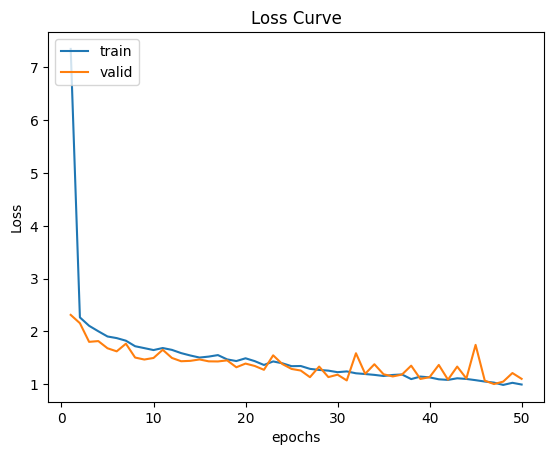

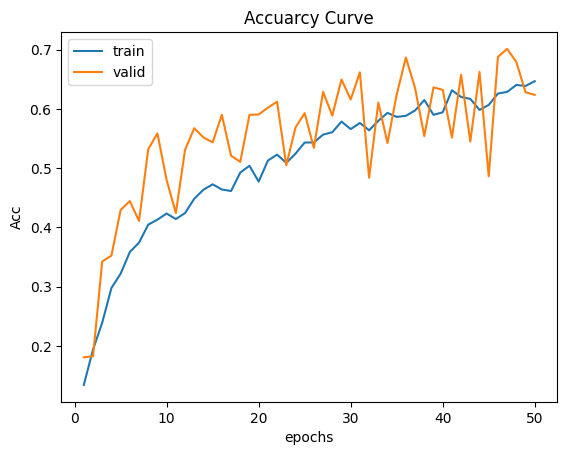

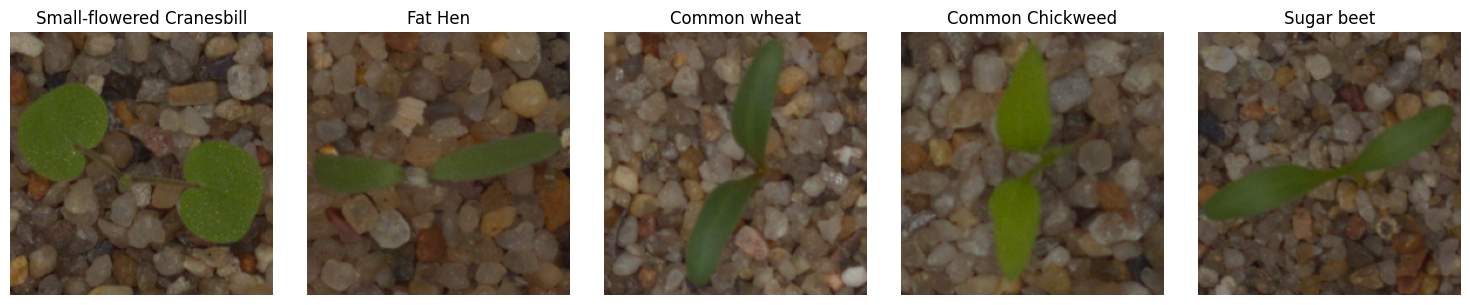

In [ ]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

In [ ]:
# Test model to debug
x = torch.rand(1, 3, 224, 224)
model = VGG16(num_classes=12)
y = model(x)
print(y)

tensor([[ 0.4093,  0.2292,  0.2221,  0.4226, -0.2982,  0.1779, -0.0226,  0.1400,
          0.0447,  0.0283,  0.2653,  0.0302]], grad_fn=<AddmmBackward0>)


Rerun training for VGG16 model

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 5.216090849467686, Avg train acc: 0.21414984464645387


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 2.4482463465796576, Avg valid acc: 0.17032163672977024


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 2.017608778817313, Avg train acc: 0.33592779551233565


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.965175496207343, Avg valid acc: 0.36686769127845764


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.8180438109806605, Avg train acc: 0.3985830749784197


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.8881853421529133, Avg valid acc: 0.38075658016734654


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.7251880713871548, Avg train acc: 0.4427795035498483


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.8249535428153143, Avg valid acc: 0.296600878238678


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.625757919039045, Avg train acc: 0.4501746892929077


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.6277366346783109, Avg valid acc: 0.41721491350067985


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.546926304272243, Avg train acc: 0.47144798125539505


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5714632272720337, Avg valid acc: 0.42132675647735596


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.5786413328988211, Avg train acc: 0.4556288821356637


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.435699807273017, Avg valid acc: 0.5157163739204407


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.5470417499542237, Avg train acc: 0.4803765526839665


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5438466336992052, Avg valid acc: 0.4520285063319736


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.521378973552159, Avg train acc: 0.4726902178355626


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.6288834942711725, Avg valid acc: 0.4316520459122128


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.457481939452035, Avg train acc: 0.4889169250215803


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.479132850964864, Avg valid acc: 0.47459795077641803


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.4686031920569285, Avg train acc: 0.4889169250215803


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4317633973227606, Avg valid acc: 0.49022295077641803


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3931345394679477, Avg train acc: 0.5087538821356637


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5438522497812908, Avg valid acc: 0.4385051164362166


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.422176548412868, Avg train acc: 0.5021545035498483


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.577222678396437, Avg valid acc: 0.4460891816351149


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.4229006392615182, Avg train acc: 0.5067740678787231


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 2.526379108428955, Avg valid acc: 0.22249634563922882


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3701760530471803, Avg train acc: 0.5157026393072945


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5110667943954468, Avg valid acc: 0.46408991350067985


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.372917982510158, Avg train acc: 0.5147515526839666


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3725575473573473, Avg valid acc: 0.5226608183648851


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3795710597719466, Avg train acc: 0.5188664598124367


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5106643305884466, Avg valid acc: 0.5023757285541959


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.351111718586513, Avg train acc: 0.5210597821644374


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4699915647506714, Avg valid acc: 0.4862024850315518


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3020894323076522, Avg train acc: 0.5398097821644374


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5165142483181424, Avg valid acc: 0.4711257285541958


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3715041194643294, Avg train acc: 0.5429347821644375


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4632374445597331, Avg valid acc: 0.4815423952208625


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3505056517464773, Avg train acc: 0.5414013981819152


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.599576473236084, Avg valid acc: 0.45084064536624485


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3061961548668997, Avg train acc: 0.5514751553535462


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4021315707100763, Avg valid acc: 0.537737574842241


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2917586769376481, Avg train acc: 0.5576669250215803


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2932255135642157, Avg valid acc: 0.5592105256186591


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.3390510422842843, Avg train acc: 0.5577639750071934


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.582645575205485, Avg valid acc: 0.47752192947599625


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2784252660615103, Avg train acc: 0.5629270195960998


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2871585687001545, Avg valid acc: 0.5742872820960151


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2652787140437536, Avg train acc: 0.5757763981819153


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.336221522755093, Avg valid acc: 0.5313413739204407


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2404106310435703, Avg train acc: 0.573039596421378


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2368690835105047, Avg valid acc: 0.5528143246968588


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1836511492729187, Avg train acc: 0.5929347821644374


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2097006373935275, Avg valid acc: 0.5939327478408813


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2301535078457424, Avg train acc: 0.5823175464357648


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.345965027809143, Avg valid acc: 0.5638706154293485


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2085235221045358, Avg train acc: 0.586180124112538


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4142022397783067, Avg valid acc: 0.4809027777777778


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1541401267051696, Avg train acc: 0.6108501553535461


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3152376015981038, Avg valid acc: 0.553362574842241


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.2099966440882002, Avg train acc: 0.5936335410390582


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3958033058378432, Avg valid acc: 0.5597587691413032


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1492852006639753, Avg train acc: 0.6004270195960999


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4552183945973713, Avg valid acc: 0.5140716367297702


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1572938697678703, Avg train acc: 0.6203222053391593


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.6996606720818415, Avg valid acc: 0.44563231203291154


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.1239201937402998, Avg train acc: 0.6330163053103856


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.5973855786853366, Avg valid acc: 0.47688231203291154


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0780041439192636, Avg train acc: 0.6314829196248736


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0691774023903742, Avg valid acc: 0.6669407884279887


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0511589918817792, Avg train acc: 0.6422360249928065


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3322644763522677, Avg valid acc: 0.5446820192866855


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0294592329433987, Avg train acc: 0.6502329196248736


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.2993390825059679, Avg valid acc: 0.5656067265404595


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0542790429932731, Avg train acc: 0.6555900624820165


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.4854224522908528, Avg valid acc: 0.5172697371906705


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.086096375329154, Avg train acc: 0.6373835410390581


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1467746761110094, Avg valid acc: 0.640899121761322


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0139319249561856, Avg train acc: 0.6557841624532427


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0783238940768771, Avg valid acc: 0.6681286560164558


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0485859104565212, Avg train acc: 0.6612965839249747


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0687961909506056, Avg valid acc: 0.6682200299368964


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 1.0523258566856384, Avg train acc: 0.6631211178643363


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.1046531664000616, Avg valid acc: 0.6785453226831224


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9942545652389526, Avg train acc: 0.6792507767677307


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.200184252527025, Avg valid acc: 0.609649121761322


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9591714007513864, Avg train acc: 0.681832298210689


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.062063992023468, Avg valid acc: 0.6727887458271451


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9432382277079991, Avg train acc: 0.6890722053391592


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.3019293149312336, Avg valid acc: 0.587536546919081


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9390214375087194, Avg train acc: 0.6885287267821175


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0539840194914076, Avg valid acc: 0.6553362607955933


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9265448314802988, Avg train acc: 0.6901591624532427


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.0291244586308796, Avg valid acc: 0.6902412308586968


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9481341055461339, Avg train acc: 0.6820263981819152


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 1.029759234852261, Avg valid acc: 0.6930738290150961


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/35 [00:00<?, ?it/s]

Avg train Loss: 0.9290152975491115, Avg train acc: 0.6991847821644375


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/9 [00:00<?, ?it/s]

Avg valid Loss: 0.9885042640897963, Avg valid acc: 0.7300804124938117


  0%|          | 0/794 [00:00<?, ?it/s]

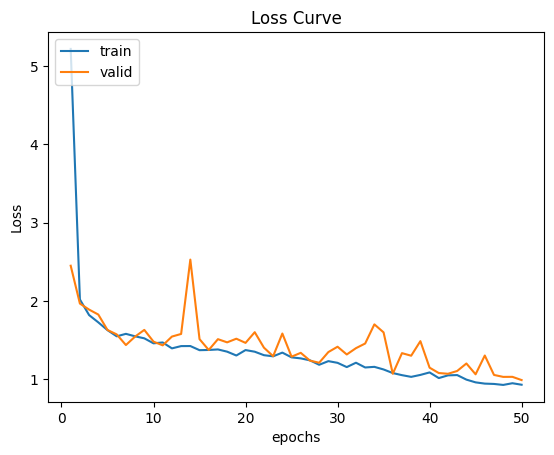

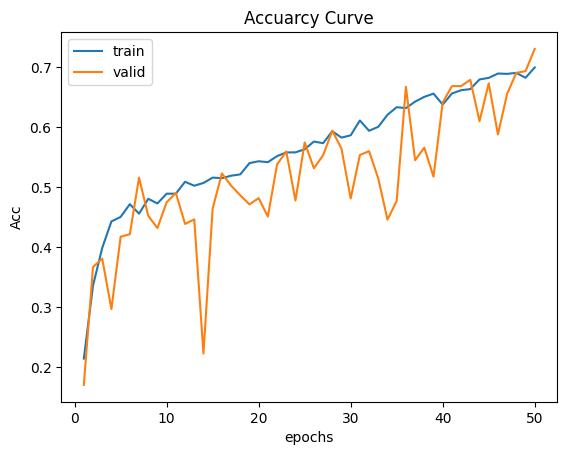

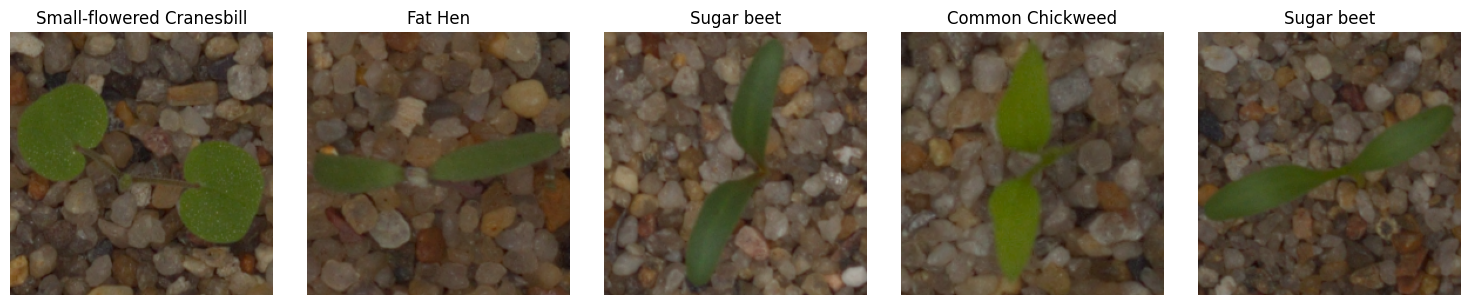

In [ ]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()